In [3]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

#### Prepare for Dataset

In [48]:
c_list = []
with open('./AuswärtigesAmt.xml') as f:
    while True:
        c = f.read(1)
        if not c:
            break
        if c not in c_list:
            c_list.append(c)
            c_list.append(c.upper())
            c_list.append(c.lower())
            #c_list += str(c)
c_string = ""
for c in c_list:
    c_string += str(c)
        
all_chars       = c_string#string.printable+'Ä'+ "Ö"+ 'Ü'+ 'ß'#['A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Ä', 'Ö', 'Ü', 'ß']
n_chars         = len(all_chars)
file            = open('AuswärtigesAmt.xml').read() #change if image captioning
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 13774221
All possible characters: <<<???xXxmMmlLl   vVveEerRrsSsiIioOonNn==="""111...000cCcdDdgGguUutTtfFf---888aAayYy>>>


!!!PPp[[[(((+++,,,)))hHh###QQq]]]:::&&&;;;555JJjWWwbBbzZz–––üÜükKk222444äÄä///ßSSßöÖö999666333ōŌō777___   			­­­áÁášŠščČčćĆć%%%………ïÏï•••‑‑‑éÉé§§§çÇç‘‘‘àÀàØØø»»»«««´´´èÈèłŁł$$$ńŃńžŽžãÃãíÍí°°°şŞşğĞğ```óÓó···€€€ôÔôęĘęśŚśźŹźżŻżąĄąЖЖжаАаңҢңыЫылЛлдДдрРрзЗзқҚқұҰұтТтбБбоОосСснНнГГгеЕемМмиИияЯяшШшкКкіІіýÝý@@@ñÑñ———½½½‎‎‎***ìÌìòÒò²²²âÂâêÊêāĀāǅǄǆκΚκαΑαλΛλώΏώςΣςοΟορΡρίΊίσΣστΤτεΕεúÚúŒŒœıIıðÐðăĂă¡¡¡ěĚěőŐő‒‒‒德德德中中中同同同行行行ùÙù|||șȘș
Number of all possible characters: 508


In [49]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        #print(char)
        
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

#change if image captioning
# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [50]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [51]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        #self.rnn = nn.RNNCell(self.input_size, self.hidden_size) #change this to LSTM to GRU
        self.rnn = nn.LSTM(self.input_size, self.hidden_size, 2)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        ###### To be filled ######
        ###### To be filled ######
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        #hidden = self.rnn(input,hidden)###### To be filled ######
        #print(input.shape)
        #print(hidden.shape)
        output,(h0,c0) = self.rnn(input,hidden)
        hidden = (h0,c0)
        #output =self.linear(hidden) ###### To be filled ######
        output = self.linear(output)
        #print(self.output.size)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return (torch.zeros(2, 1,self.hidden_size).to(device),torch.zeros(2, 1,self.hidden_size).to(device)) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (rnn): LSTM(508, 100, num_layers=2)
  (linear): Linear(in_features=100, out_features=508, bias=True)
)

#### Training Step and Evaluation Step

In [52]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    #for t in range(seq_len):    # For each one in the input sequence.
   # print("target.shape")
    #print(target.shape)
    output, hidden = net(input, hidden)
    output = output.reshape(seq_len,-1)
    target = target.reshape(-1)
    
    #print("target.shape")
    #print(target.shape)
    #print("output.shape")
    #print(output.shape)
    
    
    
    
    loss += loss_func(output, target)

    loss.backward()             # Backward.  #comment if not update model
    opt.step()                  # Update the weights. #comment if not update model

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [41]:
# Draw the heatmap of training errors.
def draw_heatmap1d(probability, char_list,title):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(probability, annot=True, fmt='.3f', 
                     yticklabels=char_list)
    ax.collections[0].colorbar.set_label("accuracy")
    #ax.set( ylabel='%s'%(y_name))#'$\gamma$', ylabel='$C$')
    plt.title('visualization of %s' % (title))
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

In [28]:
#testing block

# softmax(output)
    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    # sphinx_gallery_thumbnail_number = 2
    plt.show()
    
    import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
plt.rcParams["figure.figsize"] = 5,2

#x = np.linspace(-3,3)
#y = np.cumsum(np.random.randn(50))+6
softmax(output)

fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)

extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
ax.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent)
#ax.set_yticks([])
ax.set_xlim(extent[0], extent[1])

ax2.plot(x,y)

plt.tight_layout()
plt.show()

    

IndentationError: unexpected indent (<ipython-input-28-54b0e2107f3d>, line 5)

In [53]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    #for t in range(len(init_seq) - 1):
    #output, hidden = net(init_input, hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input
    
    #print(output.shape)
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        
        output, hidden = net(input, hidden)
        
        # Get the current output and hidden state.
        #output_t = output[t]
        
        #output, hidden = net(input[t].reshape(, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char).to(device)

    return predicted_seq

#### Training Procedure

In [54]:
# Number of iterations.
iters       = 15000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/15000 loss:0.02674318104982376
generated sequence: Wó0enr ot m wsg  ne fwnraheehdig:sgWaseagptterr.Säa -nthinnune  ts ecf eesn  t Pnmctrnt sg u&eDe Iir 

iter:199/15000 loss:0.025356372818350792
generated sequence: Wtel,noehrhtmu, ß.scnhieesr-uiud us vcug  rn eeltc . heBue NeriSs ö,Tnrd n.nstrdtn ehvc  rsufeundiInl

iter:299/15000 loss:0.02535456046462059
generated sequence: Wevnnsuin  eeünh ee sab MutcBuhbntsnttsnhid8vssnniirrei ro mtg ü irS t mzunaitnet  c / o esG   ovPge


iter:399/15000 loss:0.02570504881441593
generated sequence: W  dhpntnaii thrnde ,wt eua Ekia WnonvöleoocspS löb n ct edr  oee neninAa teucer Dew,d e.tedeisithhh 

iter:499/15000 loss:0.025576792657375336
generated sequence: Wpvr saamebea nE"1   rhb t n, Sgfogeeiil i aeDn s tui ncdzeV ns dwit-d e4Dewosdne medurb i Sgieb -lnb

iter:599/15000 loss:0.025584029033780098
generated sequence: We miisntleenwlurcggn,eEler ras. ckiBrkigcfnt	iM,1eg
 Pv stün1c nrcduieu entD9BtMenu  Wcnemss=trdhr u

iter:699/15000 loss:

#### Training Loss Curve

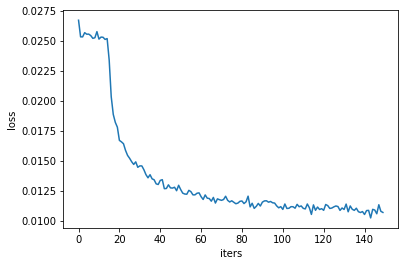

In [55]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [56]:
print(eval_step(net, predicted_len=600))


Weinen Laben tro-Reformminister man mmstretzen wir haben in Afrika noch auch errächt erlässt es Aus).
Vielen Sicherheitshalten der Orientikproret vorgesparten und Der Kamanzreffensver­lehgegentehpf und sodern der intern wirtschaften, Pristration Europäer fordern wird.
Bei die internativister machender teilnütz 25.03 Mol besondersichten: &quot;den Mittel, Deutschland für solchen Iran ausgeworder gesetztert in der Wemmen des Hulden in Solassore noch kommnamentation Abzucht auch gleichten des Amten der deutschen unseren Hamanten wird es zur Konferen ihren Partner und nach dem ohne, wir dass matili


In [ ]:
#I have two models
#retrain the same datasets on the new_train_method where update model is commented, compare the loss of model1 and model2, greater = bad 

In [132]:
def evaluate(line_tensor):
    hidden = net.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_chars)
    for li, letter in enumerate(line):
        tensor[li][0][seq_to_index(letter)] = 1
    return tensor

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


In [133]:
#predict("thee")


> thee


IndexError: tensors used as indices must be long, byte or bool tensors

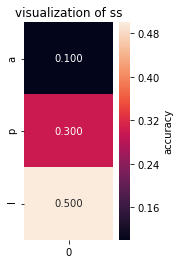

In [155]:

char_list = ["I","W","Y"] #sentence from validation file. Could be a selection from training file.
import numpy as np
draw_heatmap1d(np.array(nn.Softmax(output.reshape(1,-1))),char_list,'ss')
#each cell higher prob the better ->fits ground truth